# Supervised Learning

In [2]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
df = pd.read_csv('cleaned_data.csv')

In [3]:
def execute_fit_predict(classifier_model, X_train, y_train, X_test):
    classifier_model.fit(X_train, y_train)
    pred = classifier_model.predict(X_test)
    return pred

In [4]:
def execute_evaluate(y_test, pred=None, pred_proba=None):
    # get confusion matrix
    confusion = confusion_matrix( y_test, pred)
    # get accuracy score
    accuracy = accuracy_score(y_test , pred)
    # get precision
    precision = precision_score(y_test , pred)
    # get recall
    recall = recall_score(y_test , pred)
    # get f1 score
    f1 = f1_score(y_test,pred)
    # get auc score
    roc_auc = roc_auc_score(y_test, pred_proba)
    # get fpr, tpr
    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    
    result = {
        "roc_auc": [roc_auc.round(4)],
        "precision": [precision.round(4)],
        "recol": [recall.round(4)],
        "f1": [f1.round(4)],
        "accuracy": [accuracy.round(4)],
    }

    return (confusion,pd.DataFrame(result),{"fpr":fpr,"tpr":tpr,"auc":roc_auc})

In [5]:
def execute_cross_validation(classifier_model, X_features, y_targets, folds):
    kfold = KFold(n_splits=folds)
    scores = []
    for i , (train_index, test_index) in enumerate(kfold.split(X_features)):
        # Create index pointing to training and validation data by cross-validation from the data
        X_train, X_test = X_features.values[train_index], X_features.values[test_index]
        y_train, y_test = y_targets.values[train_index], y_targets.values[test_index]
        
        # train and fit
        pred = execute_fit_predict(classifier_model=classifier_model, X_train=X_train, y_train=y_train, X_test=X_test)
        pred_proba = classifier_model.predict_proba(X_test)[:,1]
        score = execute_evaluate(y_test=y_test, pred=pred, pred_proba=pred_proba)
        scores.append({"index":i, "score":score })
    return sorted(scores, key=lambda x: x['score'][1]['roc_auc'].iloc[0], reverse=True)

In [6]:
def roc_curve_plot(y_test ,X_test, classifier_models=None, labels=[""], title=""):
    fig, _ = plt.subplots(constrained_layout=True, figsize=(4, 4))
    for idx, classifier_model in enumerate(classifier_models):
        y_pred_proba = classifier_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, 'o-', ms=1, label="{} auc={}".format(labels[idx],auc.round(4)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(loc=4)
    plt.title('ROC Curve')    
    plt.show()

In [7]:
def evaluate_visually(evaluation, fig_title=""):
    fig, axs = plt.subplots(figsize=(10, 4), ncols=3, constrained_layout=True )
    fig.suptitle(fig_title, fontsize=12)
    
    axs[0].title.set_text("SCORE")
    axs[1].title.set_text("Counfusion_Matrix")
    axs[2].title.set_text("ROC Curve")
    
    sns.heatmap(evaluation[0], annot=True, ax=axs[1], cbar=False)
    sns.heatmap(evaluation[1], cmap="YlGnBu", annot=True, ax=axs[0], cbar=False)
    
    axs[2].plot(evaluation[2]["fpr"], evaluation[2]["tpr"], 'o-', ms=1)     
    axs[2].plot([0, 1], [0, 1], 'k--')

# Decision Tree
#### Without cross validation vs With cross validation

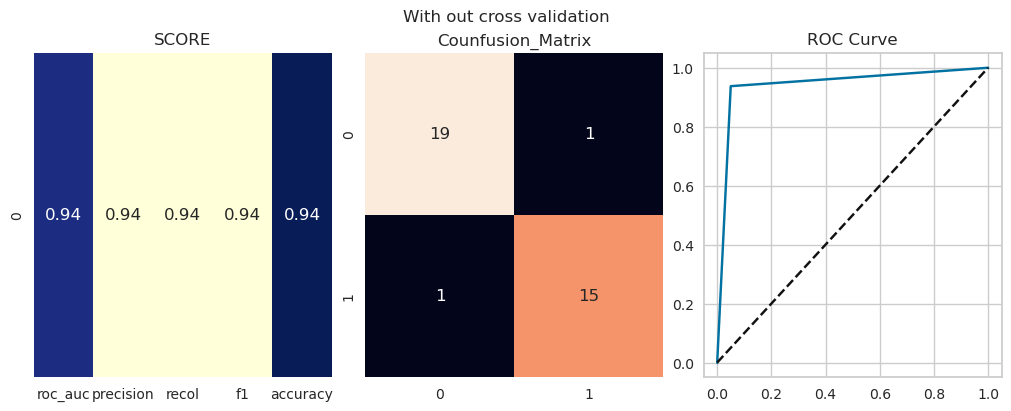

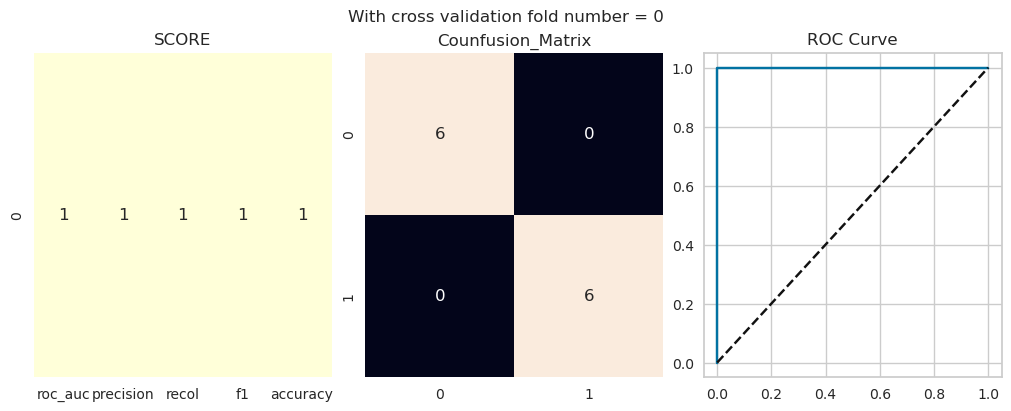

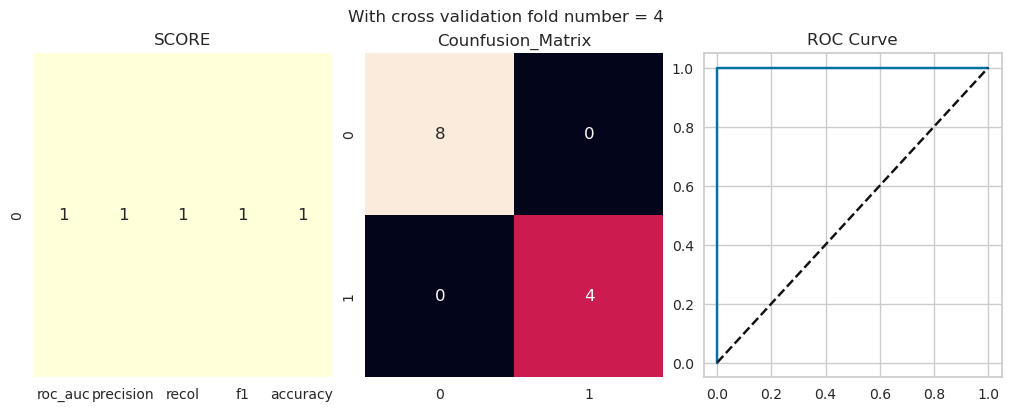

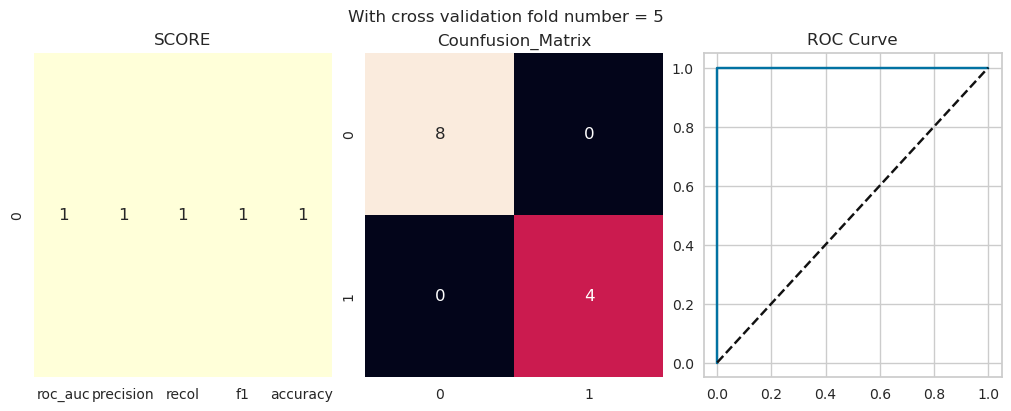

In [19]:
X_features = df.drop(['Fraud','Income'], axis=1)
# X_features = df[['Income','Balance']]
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

decision_tree = DecisionTreeClassifier()

pred = execute_fit_predict(classifier_model=decision_tree, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = decision_tree.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_visually(evaluation=evaluation, fig_title="With out cross validation")

cross_validation_scores = execute_cross_validation(classifier_model=decision_tree, 
                                                   X_features=X_features, 
                                                   y_targets=y_targets, folds=10)
for idx, x in enumerate(cross_validation_scores):
    if(idx > 2):break
    evaluate_visually(x['score'], 
                      fig_title="With cross validation fold number = {}".format(x['index']))

# cross_val_score_API = cross_val_score(decision_tree, X_features, y_targets, scoring = 'roc_auc', cv=10)
# print(cross_val_score_API)


# Random Forest
#### Without cross validation vs With cross validation

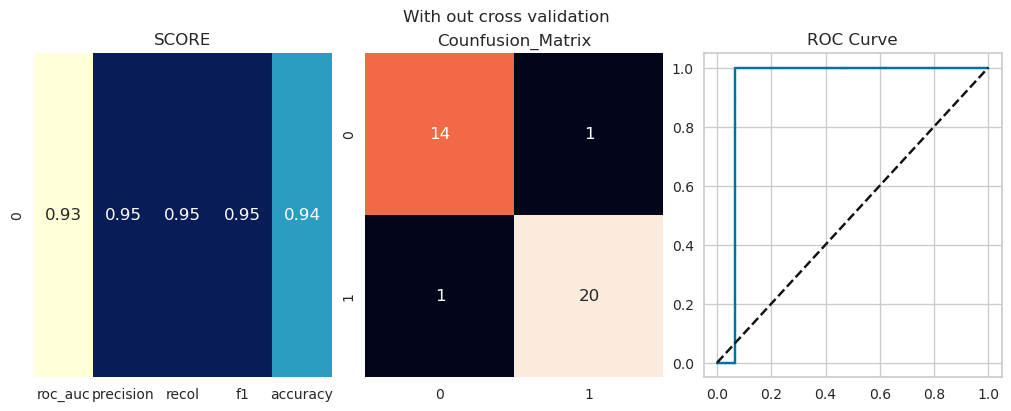

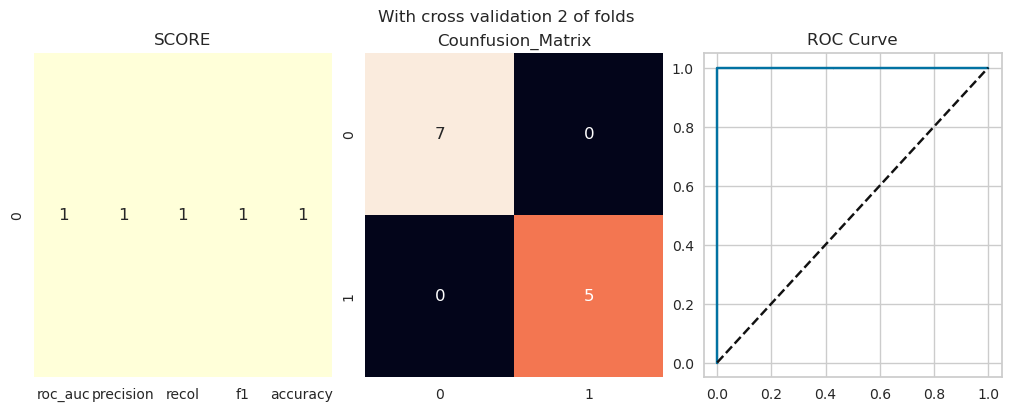

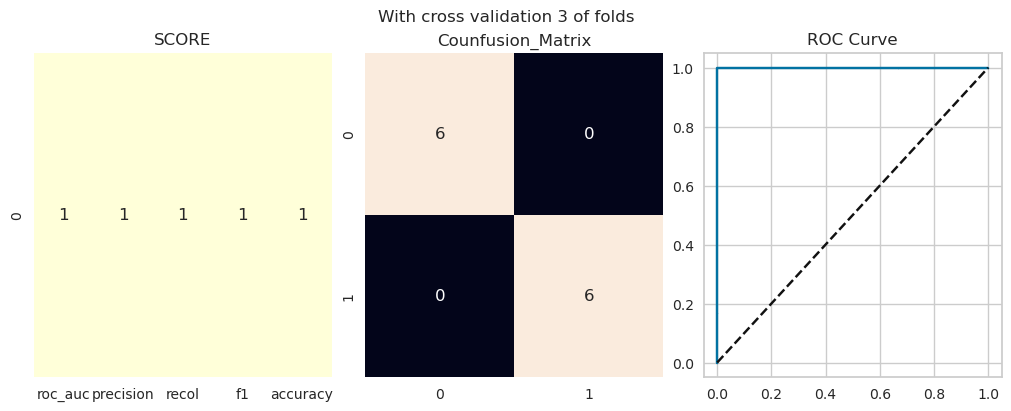

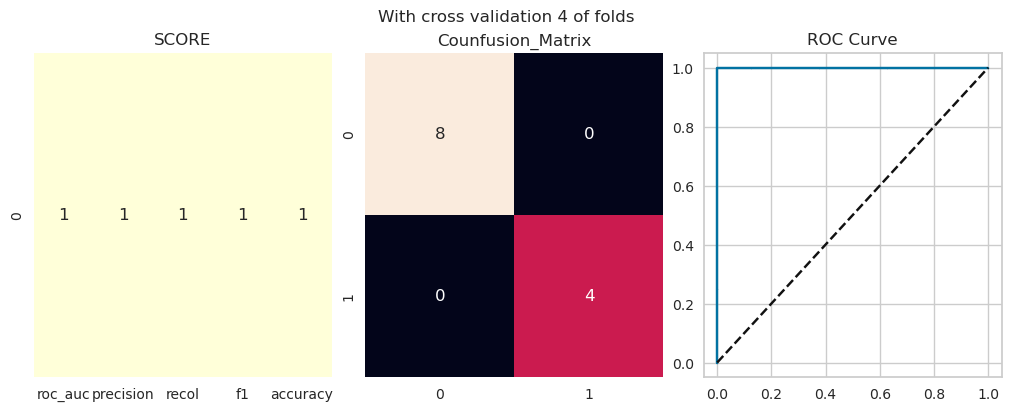

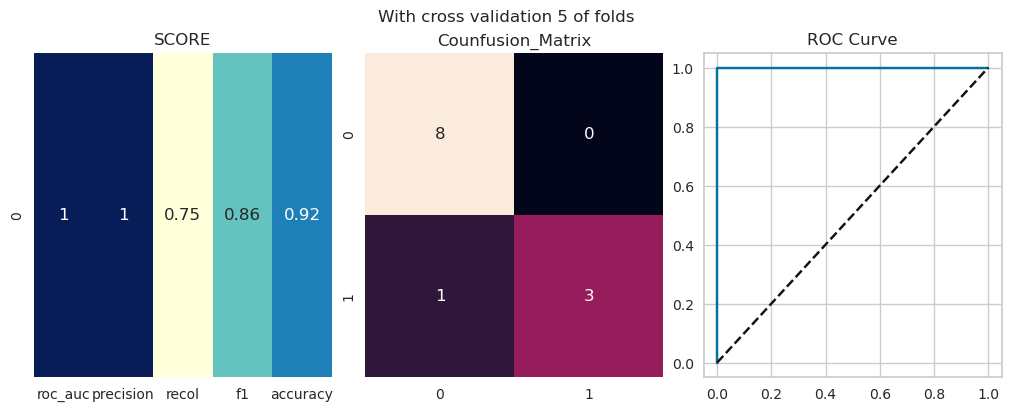

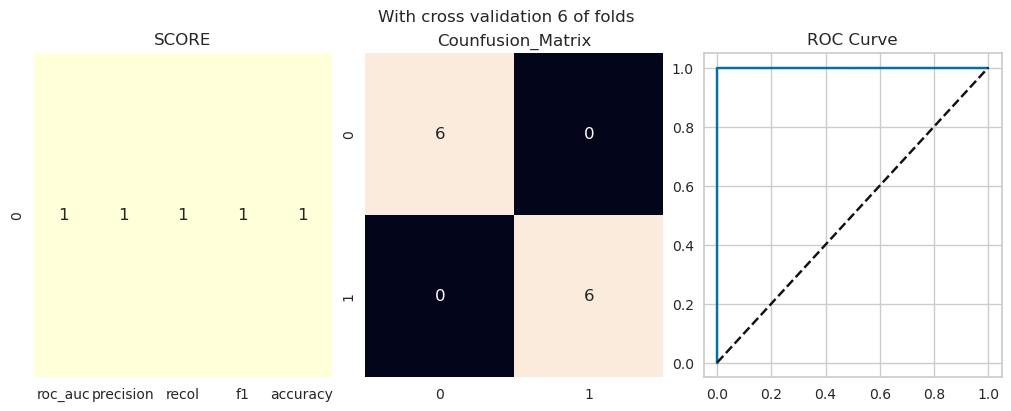

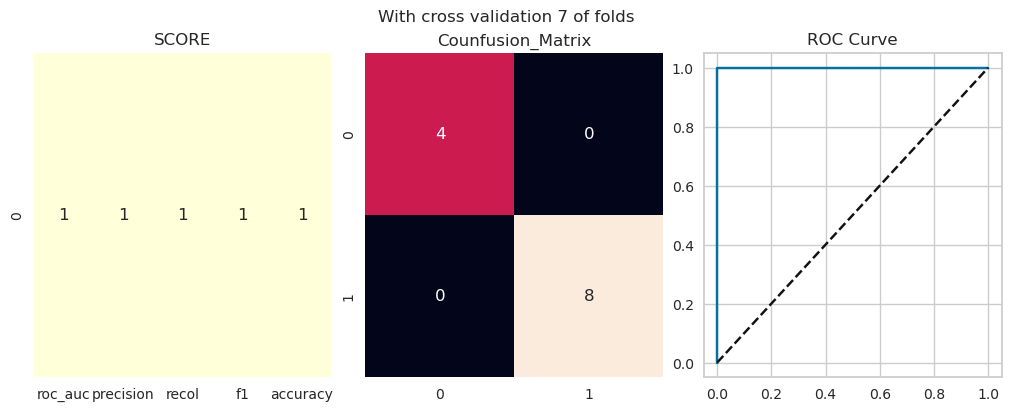

In [20]:
X_features = df.drop(['Fraud','Income'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

random_forest = RandomForestClassifier()

pred = execute_fit_predict(classifier_model=random_forest, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = random_forest.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_visually(evaluation, fig_title="With out cross validation")

cross_validation_scores = execute_cross_validation(classifier_model=random_forest, X_features=X_features, y_targets=y_targets, folds=10)
for idx, x in enumerate(cross_validation_scores):
    if(idx > 5):break
    evaluate_visually(x['score'], fig_title="With cross validation {} of folds".format(x['index']))


# Compare Decision Tree VS Random Forest with roc_curve

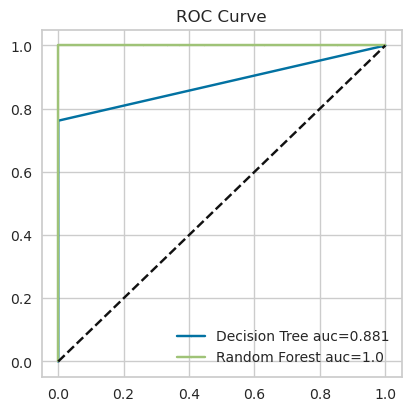

In [21]:
X_features = df.drop(['Fraud','Income'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.4)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

roc_curve_plot(y_test=y_test, X_test=X_test, classifier_models=[decision_tree, random_forest],labels=["Decision Tree","Random Forest"])



### Visualise Dicision process (Decision Tree VS Random Forest)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


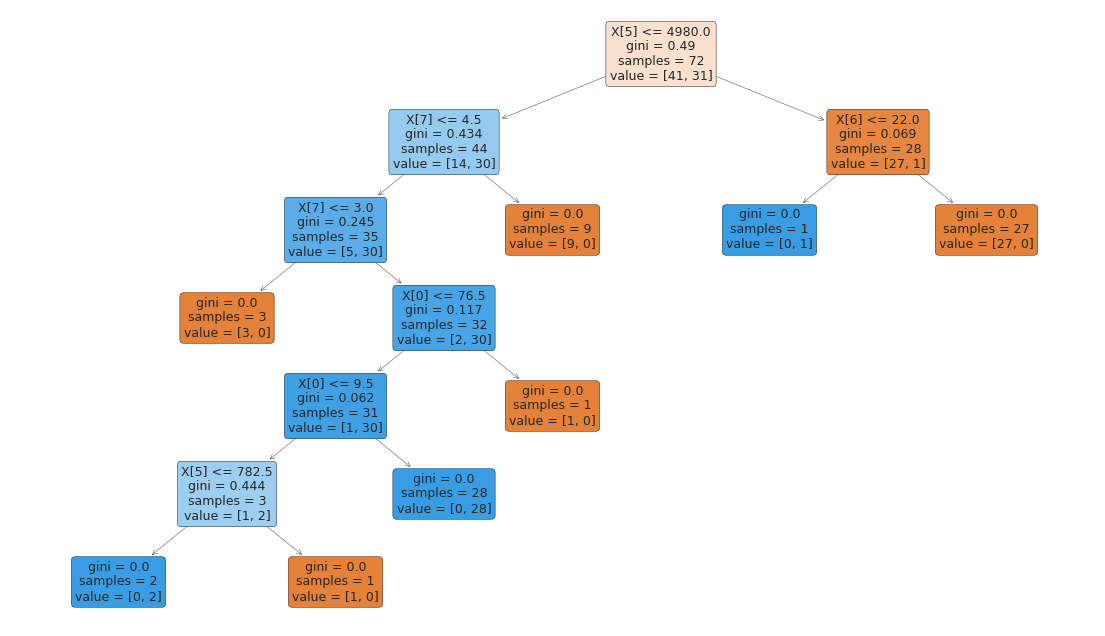

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu S

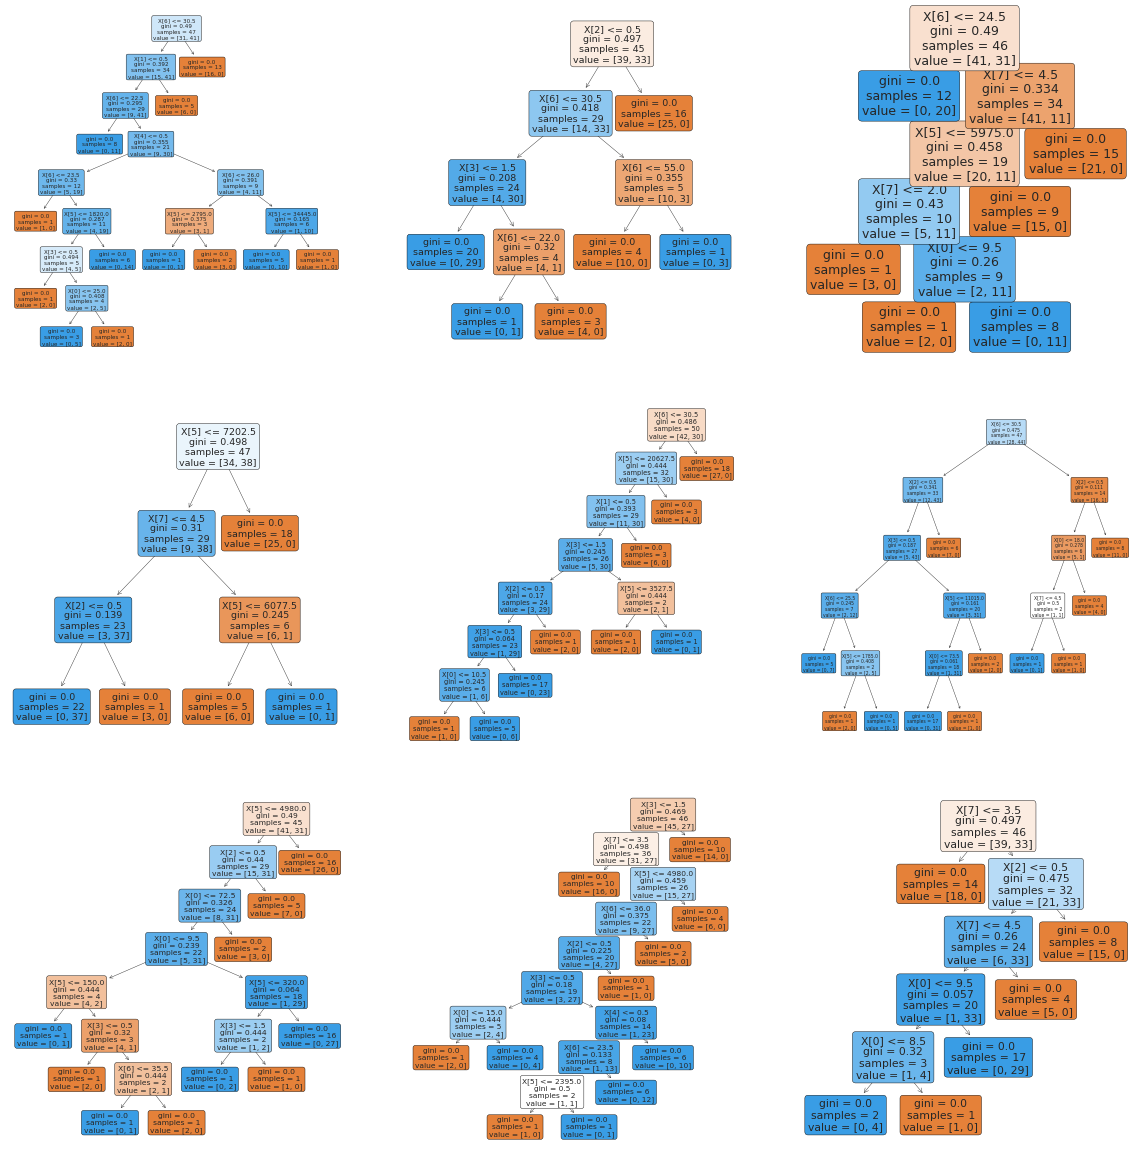

In [22]:
fig, ax = plt.subplots(figsize=(14, 8))
plot_tree(decision_tree, fontsize=9, filled=True,rounded=True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=3)
fig.tight_layout()
for i, model in enumerate(random_forest.estimators_):
    if i > 8:break
    row = int(i/3)
    col = i%3
    plot_tree(random_forest.estimators_[i], filled=True, impurity=True,rounded=True, ax=ax[row][col])
plt.show()


#### Decision tree and Random Forest feature inportance


            Decision Tree Feature Inportance
Post-code                           0.068450
Employed                            0.000000
Home Owner                          0.000000
Education                           0.000000
Gender                              0.000000
Balance                             0.442407
Age                                 0.054625
Colour                              0.434518


<AxesSubplot:xlabel='Decision Tree Feature Inportance'>

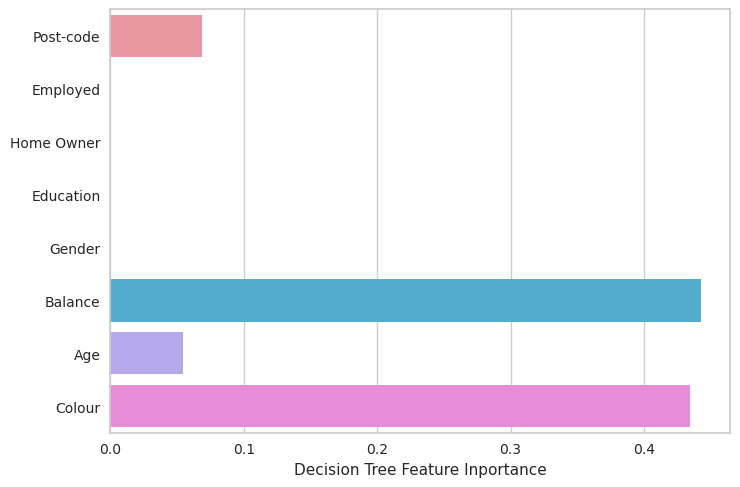

In [23]:
dt_df = pd.DataFrame(decision_tree.feature_importances_, index=X_features.columns, columns=["Decision Tree Feature Inportance"])
print(dt_df)
sns.barplot(x="Decision Tree Feature Inportance", y=X_features.columns, data=dt_df)

           Random Forest Feature Inportance
Post-code                          0.089514
Employed                           0.076854
Education                          0.051715
Gender                             0.014979
Balance                            0.318624
Age                                0.190892
Colour                             0.257422


<AxesSubplot:xlabel='Random Forest Feature Inportance'>

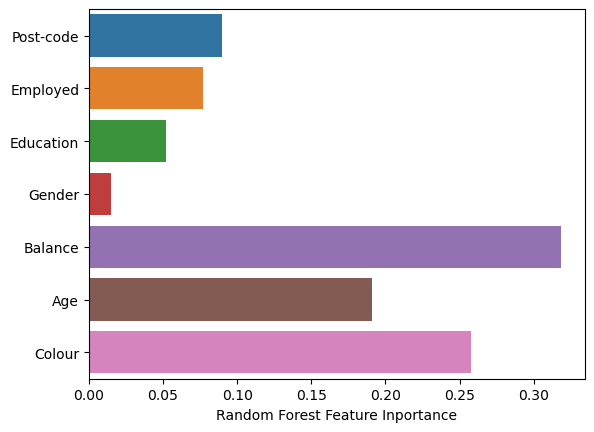

In [13]:
#random forest feature inportance
rf_df = pd.DataFrame(random_forest.feature_importances_, index=X_features.columns, columns=["Random Forest Feature Inportance"])
print(rf_df)
sns.barplot(x="Random Forest Feature Inportance", y=X_features.columns, data=rf_df)

# Unsupervised Learning (K-Means VS K-Means++)

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

def pca_df(X):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2)
    pca.fit(scaled)
    pca_df = pca.transform(scaled)
    pca_columns=['pca_1','pca_2']
    pca_df = pd.DataFrame(pca_df, columns=pca_columns)
    return pca_df
    
def inertias(X):
    inertias = []
    cluster_range = range(1,9)
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    plt.plot(cluster_range, inertias, 'bo-')
    plt.xlabel("Cluster")
    plt.ylabel("Inertia")
    plt.title('Elvow Curve')
    plt.show()

def visualise_silhouette_score(X=None, model=None):
    model.fit(X)
    visModel = SilhouetteVisualizer(model)
    visModel.fit(X)
    visModel.poof()

def visualise_correlation(df):
    corr = df.corr()
    unstack = corr.unstack()
    print(unstack[unstack < 1][unstack > 0.3].sort_values(ascending=False))
    
    plt.figure(figsize=(5, 5))
    sns.heatmap(corr, center=0, annot=True,
            fmt='.1f', square=True, cmap = 'RdYlBu_r')
    plt.show()

def pca_transform(X):
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X)
    X['pca_x'] = pca_transformed[:,0]
    X['pca_y'] = pca_transformed[:,1]
    X = X[['pca_x','pca_y']]
    return X

def fit_predict_plot(X, model):
    predictions = model.fit_predict(X)
    centroids = model.cluster_centers_
    silhouette = silhouette_score(X, predictions)
    plot_(X,predictions,centroids)
    accuracy = sum(predictions == df['Fraud']) / len(df)
    # print("centroids:\n{}, predictions:\n{},silhouette:{}, accuracy:{}".format(centroids, predictions, silhouette, accuracy))
    return (centroids, predictions, silhouette, accuracy,model.labels_)

def plot_(X,predictions,centroids):
    f, ax = plt.subplots(figsize=(6,6), ncols=1, nrows=1)
    for i,column in enumerate(X):
        if i == len(X.columns)-1: break
        ax.scatter(X[predictions==0].iloc[:,lambda X: [i]],X[predictions==0].iloc[:,lambda X: [i+1]],marker='^',c="y")
        ax.scatter(X[predictions==1].iloc[:,lambda X: [i]],X[predictions==1].iloc[:,lambda X: [i+1]],marker='s',c='m')
        ax.scatter(centroids[:, 0], centroids[:, 1], c='k', edgecolors='k', s=50)
    plt.show()

#### visualise_correlation

Income      Balance       0.676333
Balance     Income        0.676333
Employed    Home Owner    0.594028
Home Owner  Employed      0.594028
Income      Home Owner    0.529223
Home Owner  Income        0.529223
Income      Employed      0.524189
Employed    Income        0.524189
Colour      Fraud         0.408476
Fraud       Colour        0.408476
Education   Age           0.387624
Age         Education     0.387624
            Home Owner    0.379065
Home Owner  Age           0.379065
            Balance       0.356236
Balance     Home Owner    0.356236
Employed    Balance       0.348254
Balance     Employed      0.348254
Age         Income        0.321787
Income      Age           0.321787
Home Owner  Education     0.321750
Education   Home Owner    0.321750
dtype: float64


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


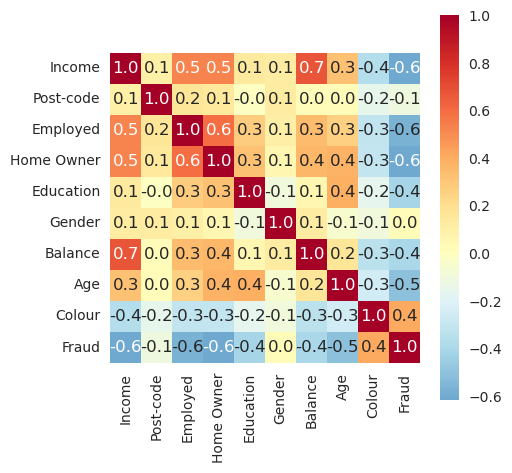

In [15]:

X_features_All = pca_df(df.drop(['Fraud','Income','Home Owner'], axis=1))
X_income_balance = pca_df(df[['Income','Balance']])
X_employed_home_owner = pca_df(df[['Employed','Home Owner']])
X_mix = pca_df(df[['Employed','Home Owner','Income','Balance']])

visualise_correlation(df)

#### fit and predict then plot

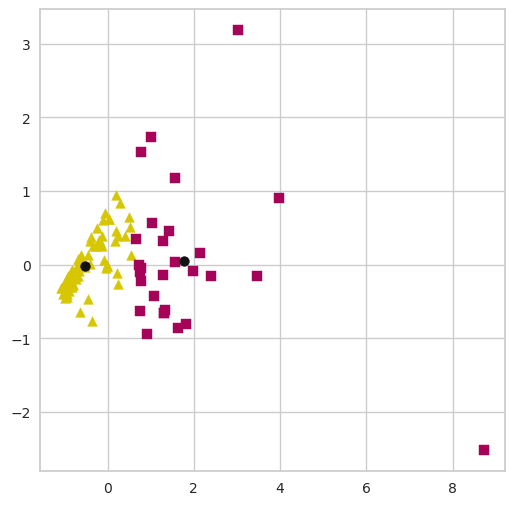

(array([[-0.53732996, -0.01542863],
       [ 1.76551274,  0.05069408]]), array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32), 0.6028000228919247, 0.3333333333333333, array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32))


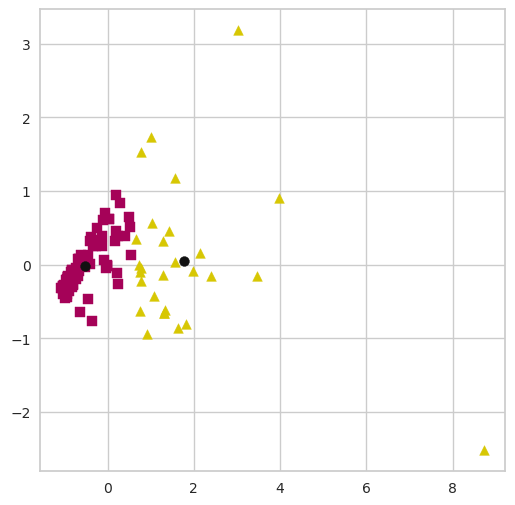

(array([[ 1.76551274,  0.05069408],
       [-0.53732996, -0.01542863]]), array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32), 0.6028000228919247, 0.6666666666666666, array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32))


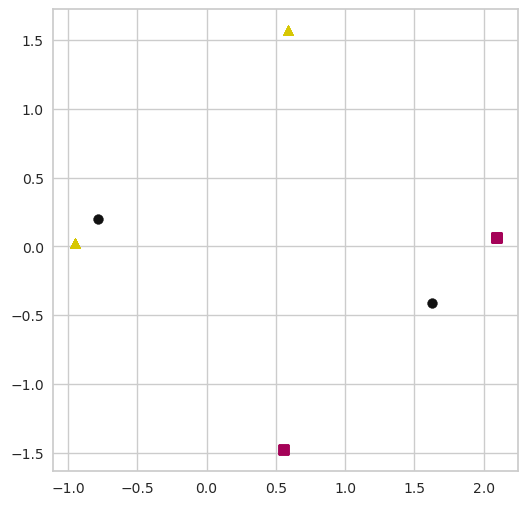

(array([[-0.78211526,  0.1991915 ],
       [ 1.62439324, -0.41370542]]), array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32), 0.7640502074883356, 0.24166666666666667, array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32))


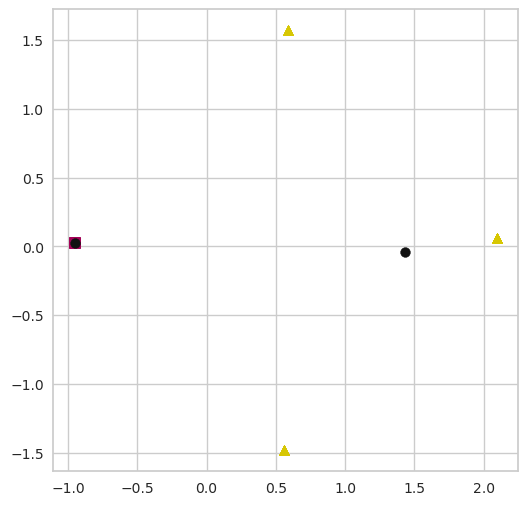

(array([[ 1.43034515, -0.041615  ],
       [-0.95356343,  0.02774333]]), array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32), 0.7737659738024114, 0.8333333333333334, array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32))


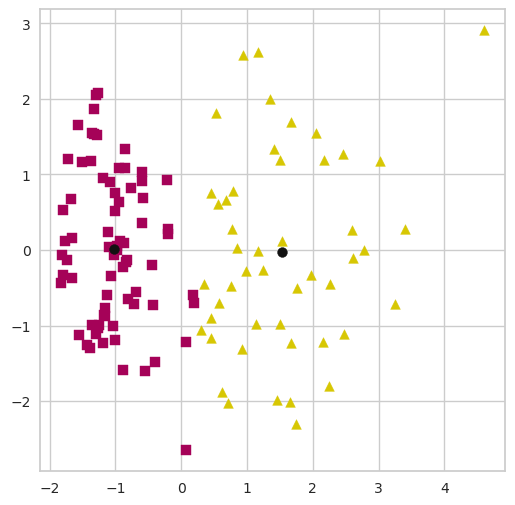

(array([[ 1.5360735 , -0.02239923],
       [-1.024049  ,  0.01493282]]), array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32), 0.4423999640997755, 0.8166666666666667, array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32))


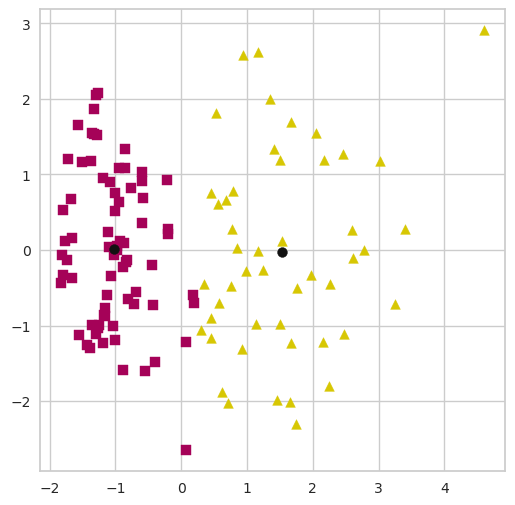

(array([[ 1.5360735 , -0.02239923],
       [-1.024049  ,  0.01493282]]), array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32), 0.4423999640997755, 0.8166666666666667, array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32))


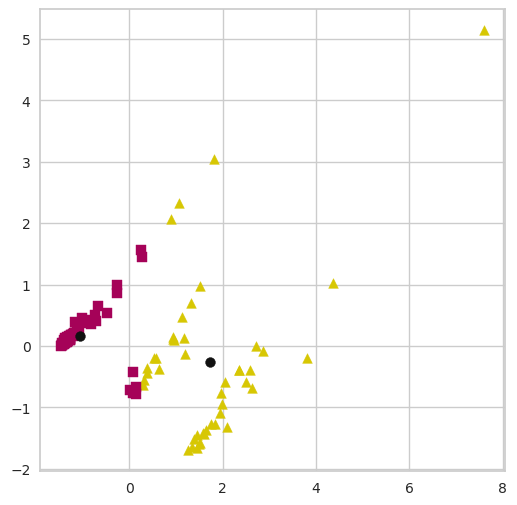

(array([[ 1.73892652, -0.26484448],
       [-1.04335591,  0.15890669]]), array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32), 0.6198619198264552, 0.8083333333333333, array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32))


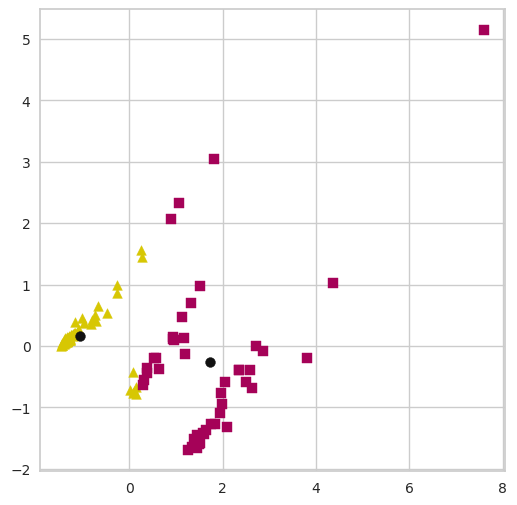

(array([[-1.04335591,  0.15890669],
       [ 1.73892652, -0.26484448]]), array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32), 0.6198619198264552, 0.19166666666666668, array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int32))


In [16]:
# Create KMeans model
kmeans_randome = KMeans(n_clusters=2, init='random')
kmeans_plus = KMeans(n_clusters=2, init='k-means++',algorithm='elkan',max_iter=1000)

print(fit_predict_plot(X_income_balance, kmeans_plus))
print(fit_predict_plot(X_income_balance, kmeans_randome))

print(fit_predict_plot(X_employed_home_owner, kmeans_plus))
print(fit_predict_plot(X_employed_home_owner, kmeans_randome))

print(fit_predict_plot(X_features_All, kmeans_plus))
print(fit_predict_plot(X_features_All, kmeans_randome))

print(fit_predict_plot(X_mix, kmeans_plus))
print(fit_predict_plot(X_mix, kmeans_randome))


#### visualise_silhouette_score

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


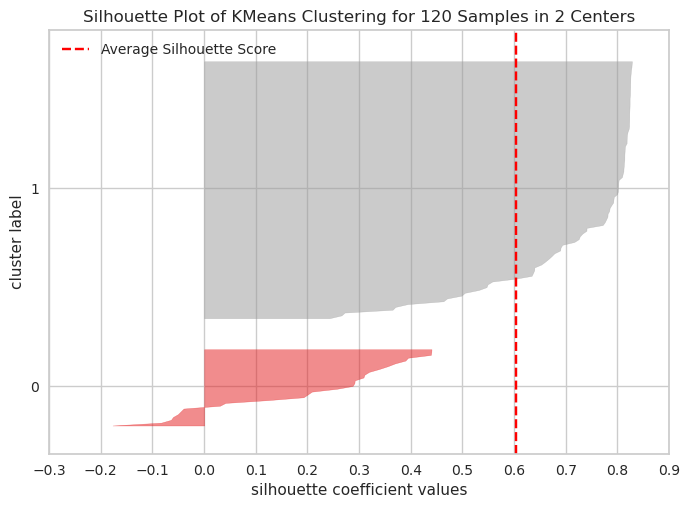

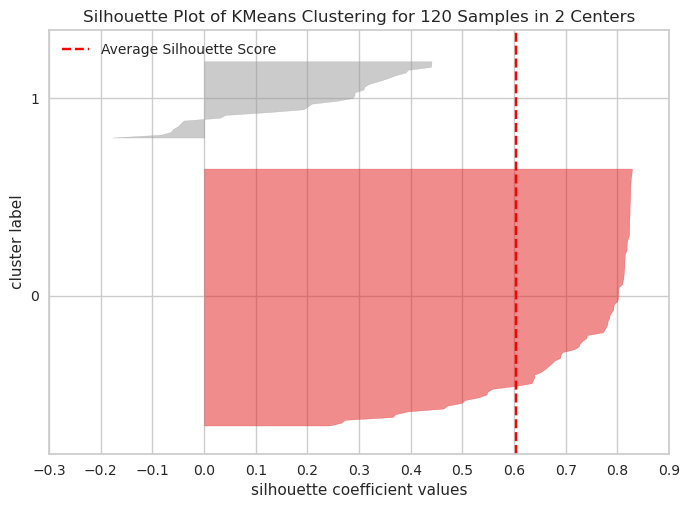

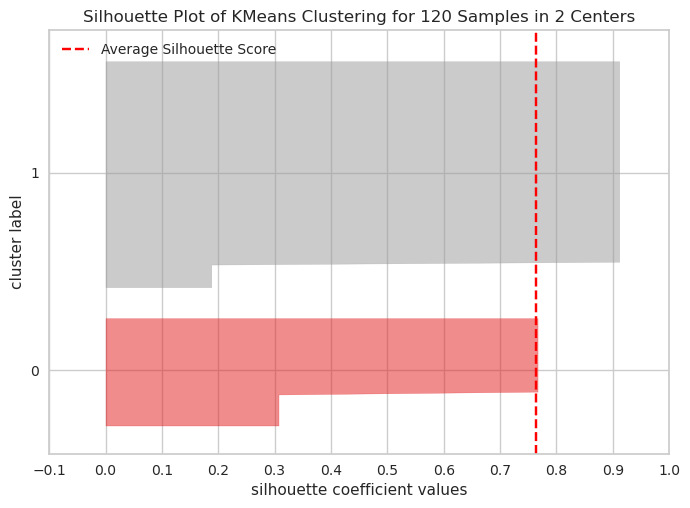

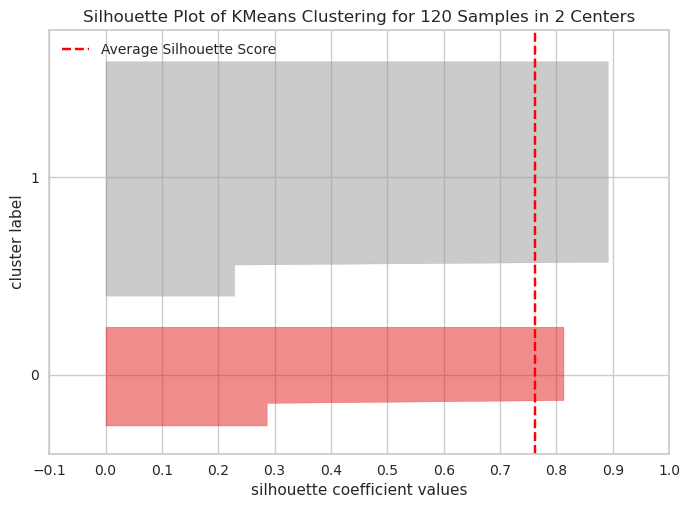

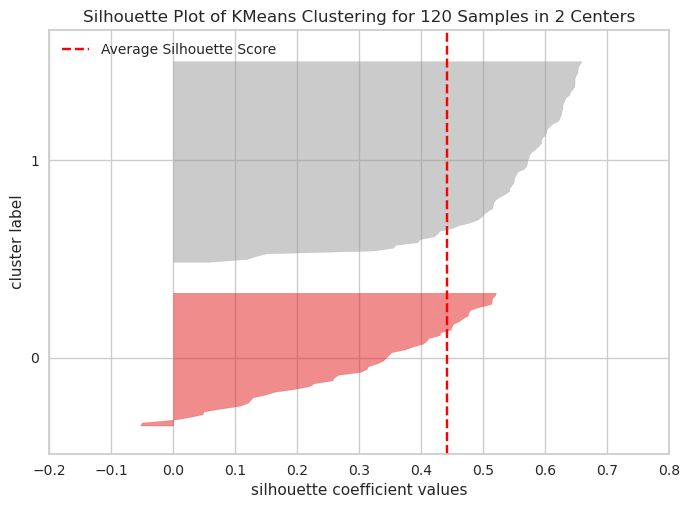

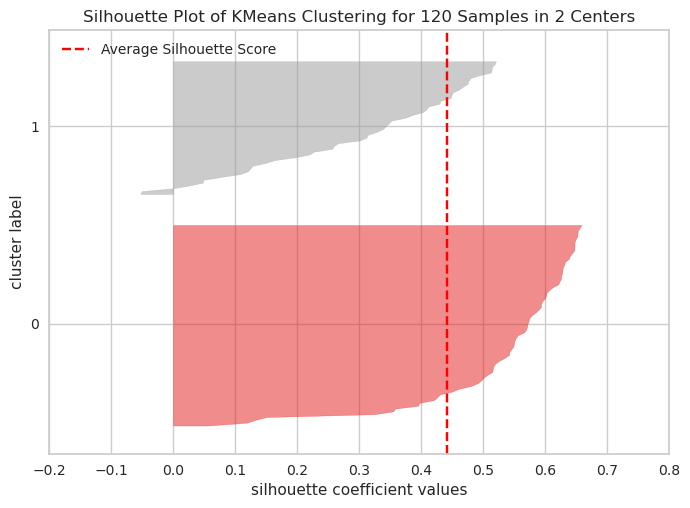

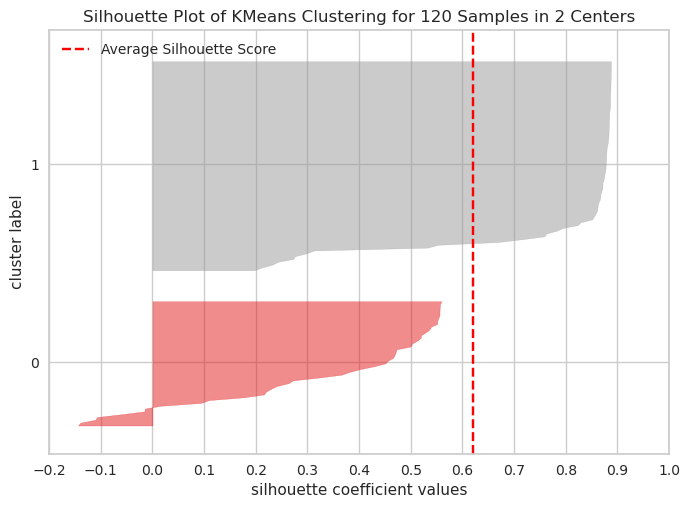

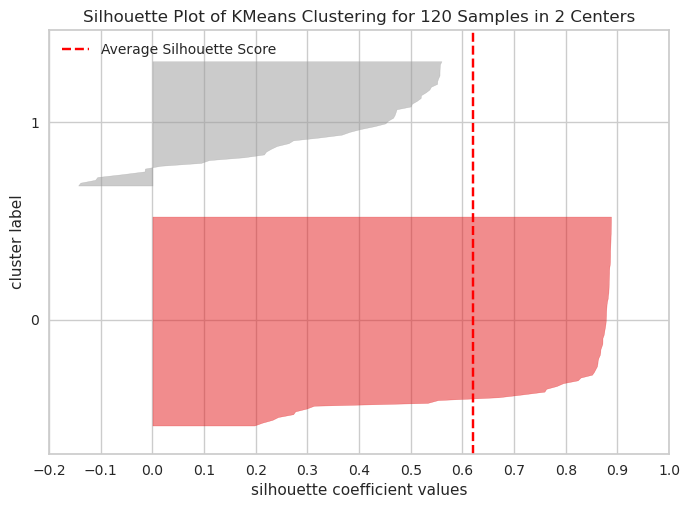

In [17]:

visualise_silhouette_score(X_income_balance,kmeans_plus)
visualise_silhouette_score(X_income_balance,kmeans_randome)

visualise_silhouette_score(X_employed_home_owner,kmeans_plus)
visualise_silhouette_score(X_employed_home_owner,kmeans_randome)

visualise_silhouette_score(X_features_All,kmeans_plus)
visualise_silhouette_score(X_features_All,kmeans_randome)

visualise_silhouette_score(X_mix, kmeans_plus)
visualise_silhouette_score(X_mix, kmeans_randome)

#### inertias

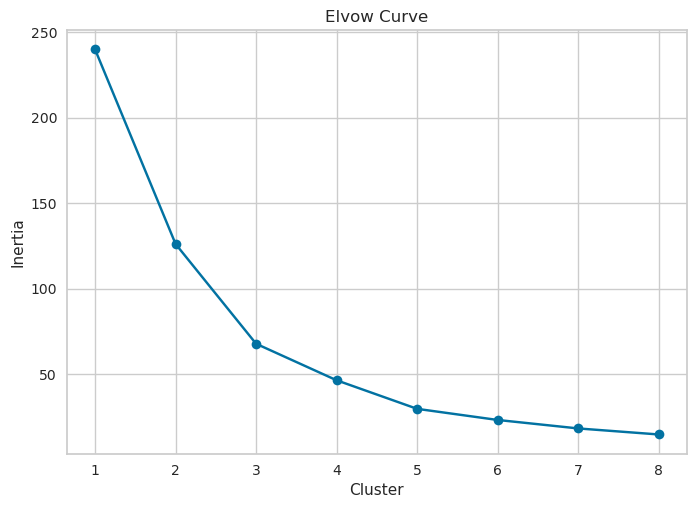

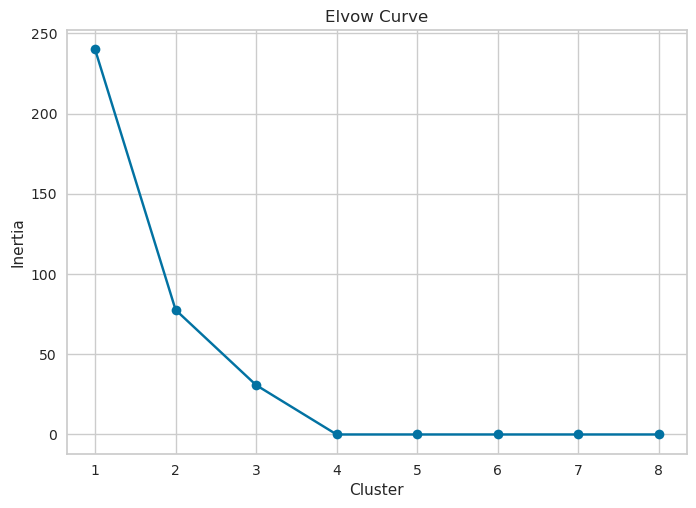

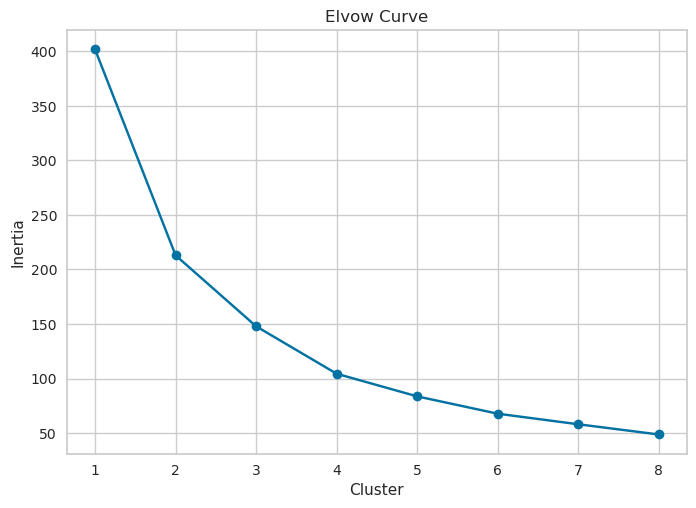

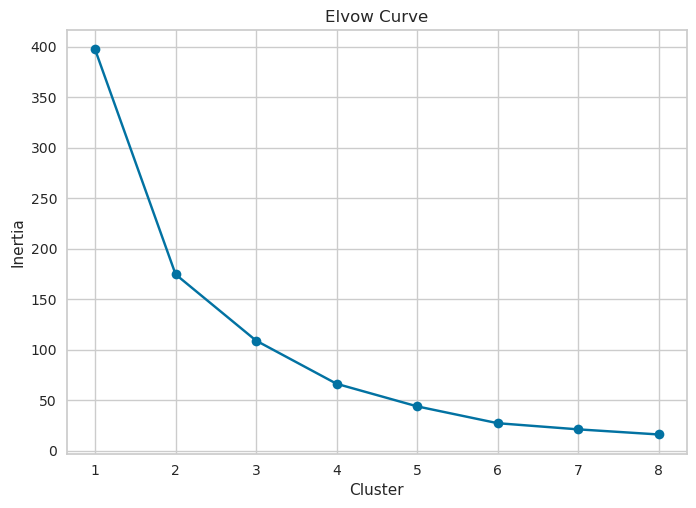

In [18]:
inertias(X_income_balance)
inertias(X_employed_home_owner)
inertias(X_features_All)
inertias(X_mix)

